# Predicting Stock Price Movement using LSTMs:
    Predicting Microsoft(MSFT) stock price movement based on the daily closing price. Creating a custom LSTM model, and training it based on a window of past 3 working days. Thereafter checking for which intervals the model works and figuring out the reasoning behind it. 

### Importing the dependencies

In [1]:
#importing dependencies:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Creating a DataFrame
Data is downloaded from yfinance as a csv file. The link to the data is [here](https://finance.yahoo.com/quote/MSFT/history/?period1=511108200&period2=1718603577).

In [2]:
#dataset available at yfinance
df = pd.read_csv('/kaggle/input/msft-history/MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9637,2024-06-10,424.700012,428.079987,423.890015,427.869995,427.869995,14003000
9638,2024-06-11,425.480011,432.820007,425.250000,432.679993,432.679993,14551100
9639,2024-06-12,435.320007,443.399994,433.250000,441.059998,441.059998,22366200
9640,2024-06-13,440.850006,443.390015,439.369995,441.579987,441.579987,15960600


In [3]:
#function to convert my string date type to datetime objects:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year = year, month = month, day = day)
dt_obj_test = '1986-02-11'
dt_obj_test = str_to_datetime(dt_obj_test)
type(dt_obj_test)

datetime.datetime

In [4]:
df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9637,2024-06-10,424.700012,428.079987,423.890015,427.869995,427.869995,14003000
9638,2024-06-11,425.480011,432.820007,425.250000,432.679993,432.679993,14551100
9639,2024-06-12,435.320007,443.399994,433.250000,441.059998,441.059998,22366200
9640,2024-06-13,440.850006,443.390015,439.369995,441.579987,441.579987,15960600


In [5]:
#using only the closing value to train our model.
df = df[['Date', 'Close']]
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-06-10,427.869995
2024-06-11,432.679993
2024-06-12,441.059998


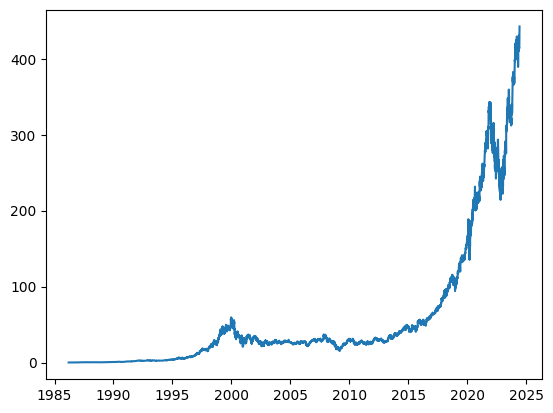

In [6]:
plt.plot(df.index, df['Close'])

In [7]:
#training the model based on past 3 working days closing data:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+dt.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = dt.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# We explore the following 2 cases here, a short term 2-year duration for training and testing, and 
# another long term 10-year window for training and testing.
# Case 1:

'''windowed_df = df_to_windowed_df(df, 
                                '2014-03-25', 
                                '2024-06-14', 
                                n=3)
'''
''''''
# Case 2:

windowed_df = df_to_windowed_df(df, '2021-03-25', '2024-06-14', n=3)
''''''

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
807,2024-06-10,424.010010,424.519989,423.850006,427.869995
808,2024-06-11,424.519989,423.850006,427.869995,432.679993
809,2024-06-12,423.850006,427.869995,432.679993,441.059998
810,2024-06-13,427.869995,432.679993,441.059998,441.579987


In [8]:
#converting the df to a numpy in a usable matrix format.
def windowed_df_to_dates_X_and_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = windowed_df_to_dates_X_and_y(windowed_df)
dates.shape, X.shape, y.shape

((812,), (812, 3, 1), (812,))

### Creating a train-test split:
Here 2 possibilities are explored, choosing the train test data sequentially, versus choosing the data in a random fashion.
In both possibilites, the train : validation : test split is kept 0.8 : 0.1 : 0.1

Case 1:

(649, 3, 1) (81, 3, 1) (82, 3, 1)
(649,) (81,) (82,)


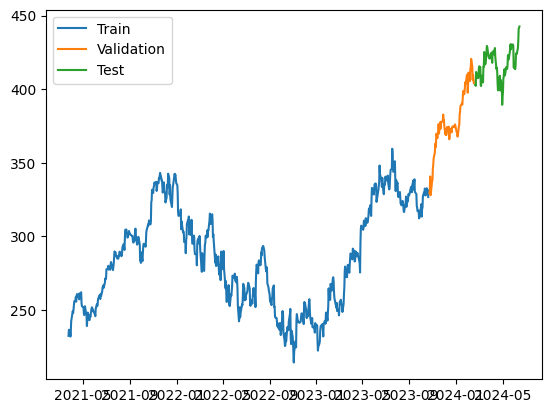

In [9]:
#creating a train test split not randomly, but sequantially

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

Case 2:
This case considers the values randomly, but there is a fundamental problem while using this method for time series data and that is this considers the fact that we know some of the future data, which we actually do no know in real time, but it is a fun exercise to try out indeed. The following commented out code handles this case of shuffling and ahuffles the data randomly and then tests it. We can see the results in the scatterplots.

In [10]:
'''x = X.reshape(X.shape[0], X.shape[1])
d = dates.reshape(dates.shape[0], 1)
x_temp = np.concatenate([d, x], axis = 1)

#splitting the data in 80:20 train test
x_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size= 0.2, shuffle = True, random_state= 42)
#splitting the data into 10:10 test val
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, shuffle = True, random_state = 42)
dates_train = x_train[:, 0]
dates_test = x_test[:, 0]
dates_val = x_val[:, 0]
X_train = x_train[:, 1:]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train = X_train.astype(np.float32)
X_test = x_test[:, 1:]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test = X_test.astype(np.float32)
X_val = x_val[:, 1:]
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_val = X_val.astype(np.float32)

#Plotting the data
plt.scatter(dates_train, y_train, c = 'blue', s= 15)
plt.scatter(dates_val, y_val, c = 'orange', s= 15)
plt.scatter(dates_test, y_test, c = 'green', s = 15)

plt.legend(['Train', 'Validation', 'Test'])
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)'''

"x = X.reshape(X.shape[0], X.shape[1])\nd = dates.reshape(dates.shape[0], 1)\nx_temp = np.concatenate([d, x], axis = 1)\n\n#splitting the data in 80:20 train test\nx_train, x_test, y_train, y_test = train_test_split(x_temp, y, test_size= 0.2, shuffle = True, random_state= 42)\n#splitting the data into 10:10 test val\nx_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, shuffle = True, random_state = 42)\ndates_train = x_train[:, 0]\ndates_test = x_test[:, 0]\ndates_val = x_val[:, 0]\nX_train = x_train[:, 1:]\nX_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)\nX_train = X_train.astype(np.float32)\nX_test = x_test[:, 1:]\nX_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)\nX_test = X_test.astype(np.float32)\nX_val = x_val[:, 1:]\nX_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)\nX_val = X_val.astype(np.float32)\n\n#Plotting the data\nplt.scatter(dates_train, y_train, c = 'blue', s= 15)\nplt.scatter(dates_val, y_val, c = 'orange

In [11]:
#defining the model: 

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2024-06-17 10:43:21.352427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:43:21.352481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:43:21.354023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 82290.0391 - mean_absolute_error: 284.8395 - val_loss: 141013.4531 - val_mean_absolute_error: 374.8921
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81217.8906 - mean_absolute_error: 282.8871 - val_loss: 137043.3906 - val_mean_absolute_error: 369.5589
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76518.2578 - mean_absolute_error: 274.4629 - val_loss: 129735.7500 - val_mean_absolute_error: 359.5351
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70086.6406 - mean_absolute_error: 262.4933 - val_loss: 117236.6406 - val_mean_absolute_error: 341.7103
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59972.1562 - mean_absolute_error: 242.4356 - val_loss: 98482.6797 - val_mean_absolute_error: 313.0693
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45133.1406 - mean_absolute_error: 209.5550 - val_loss: 73900.9844 - val_mean_absolute_error: 270.9818
Epoch 7/100
21/21 ━━━━━━━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


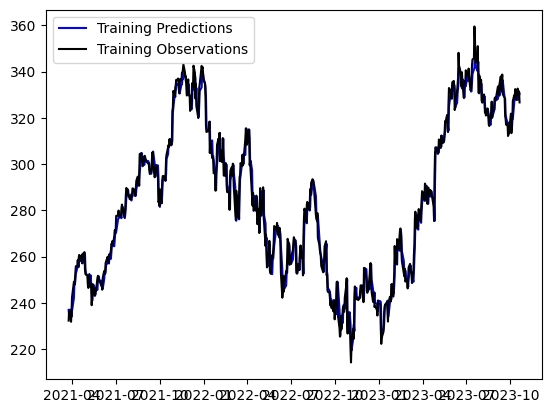

In [12]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, c='blue')
plt.plot(dates_train, y_train, c = 'black')
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


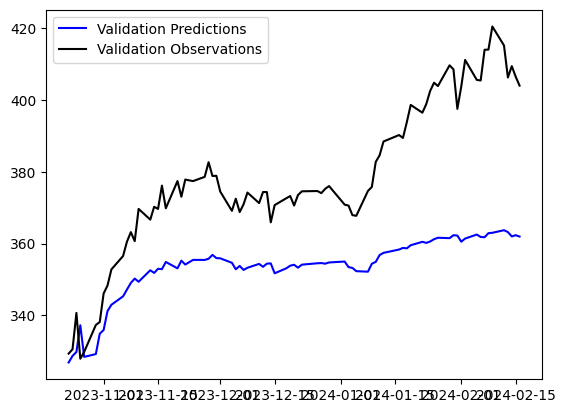

In [13]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, c = 'blue')
plt.plot(dates_val, y_val, c = 'black')
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


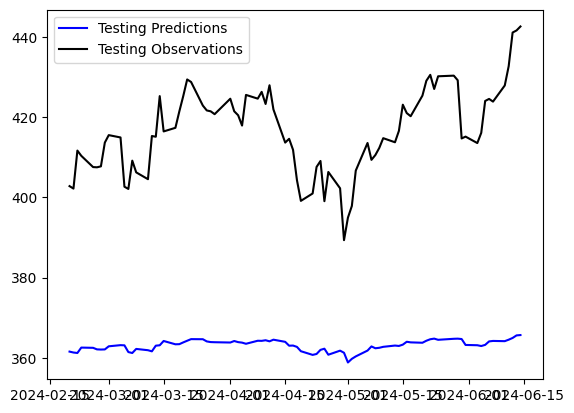

In [14]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions, c = 'blue', )
plt.plot(dates_test, y_test, c= 'black', )
plt.legend(['Testing Predictions', 'Testing Observations'])

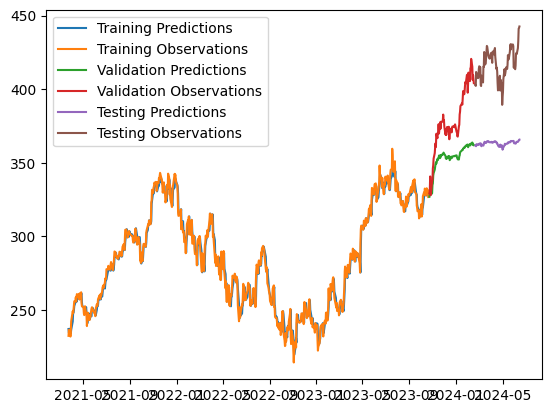

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [16]:
'''plt.scatter(dates_train, train_predictions)
plt.scatter(dates_train, y_train)
plt.scatter(dates_val, val_predictions)
plt.scatter(dates_val, y_val)
plt.scatter(dates_test, test_predictions)
plt.scatter(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])'''

"plt.scatter(dates_train, train_predictions)\nplt.scatter(dates_train, y_train)\nplt.scatter(dates_val, val_predictions)\nplt.scatter(dates_val, y_val)\nplt.scatter(dates_test, test_predictions)\nplt.scatter(dates_test, y_test)\nplt.legend(['Training Predictions', \n            'Training Observations',\n            'Validation Predictions', \n            'Validation Observations',\n            'Testing Predictions', \n            'Testing Observations'])"

## RESULTS: 
We can see here that the minute there is a big change as seen in the rise of stock in 2023-Nov, the model is unable to predict it and thus fails to predict that data, but if the change is not much, the model can track it pretty well.
We can see how it is unable to predict the volatility in the stock prices, and thus its uses are solely limited to this learning based project.


Following is an attempt to recursively make predictions and understand if we can improve the model's performance on unseen data.

In [17]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

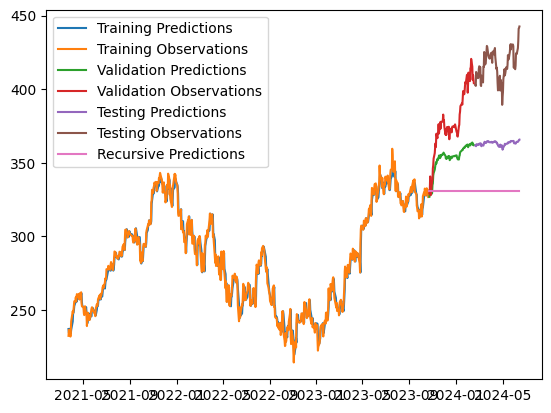

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

As we can see here, the predictions simply trail off in the unseen portion of the data and cannot follow the closing price as closely.

## Conclusion:
In this project we learnt that a memory based (LSTM) Model could be used to predict stock prices due to its ability te make predictions based off previous data. After training a single layer LSTM model, we learnt that it can predict well based on seen data, but it has quite a few disadvantages when it comes to unseen data. The model does not anticipate the big changes, but does manage to keep up with the small changes that occur. Also, it performs better if trained on short-term data than on long-term data.